## Imports

In [1]:
!pip install -q dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 5.1 MB/s eta 0:00:00


In [2]:
# basicos
import numpy as np
import pandas as pd
import os
import re
import string as s
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# misc
from lightgbm import LGBMClassifier
from wordcloud import WordCloud

In [3]:
# nltk downloads
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Carregar Dataset

In [ ]:
train_data = pd.read_csv('/content/train.csv', header=0, names=['id', 'title', 'desc'])
test_data = pd.read_csv('/content/test.csv', header=0, names=['id', 'title', 'desc'])

In [ ]:
train_data.head()

,id,title,desc
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
test_data.head()

,id,title,desc
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


## Personalização do Dataset (união do treino e teste do kaggle)

In [ ]:
def reduce_data(df, column_name, pct=50):
    # Calcular o fator de redução do dataset
    size_factor = 1 - pct / 100

    # Separar o dataset com estratificação
    _, reduced_df = train_test_split(
        df,
        test_size=size_factor,
        stratify=df[column_name],
        random_state=0
    )

    return reduced_df.reset_index(drop=True)

train_data = reduce_data(train_data, 'id')
test_data = reduce_data(test_data, 'id')

## Exploração do Dataset

In [ ]:
# shape dos datasets
print(train_data.shape)
print(test_data.shape)

(60000, 3)
(3800, 3)


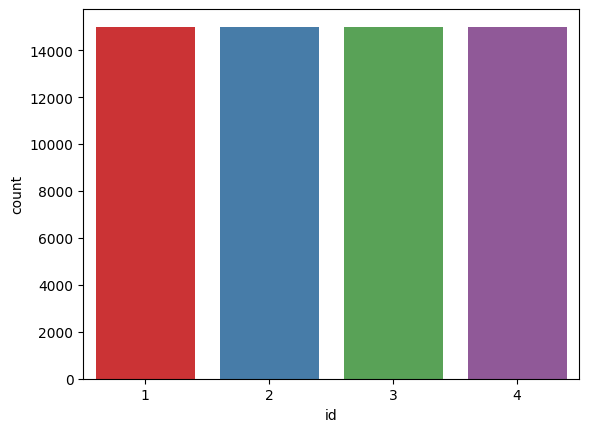

In [ ]:
# Countplot das classes no dataset de treino
sns.countplot(x = 'id', data = train_data, hue = 'id', legend = False, palette = 'Set1')
plt.show()

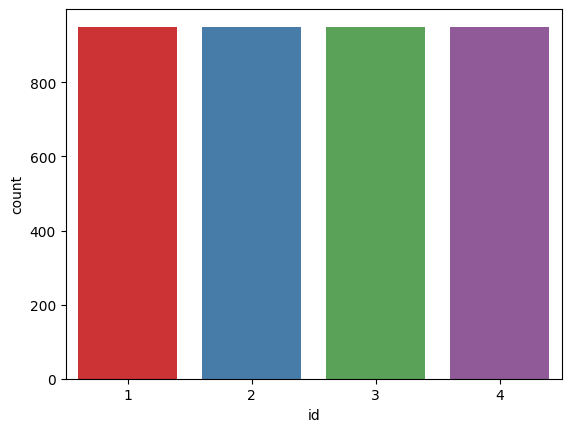

In [ ]:
# Countplot das classes no dataset de teste
sns.countplot(x = 'id', data = test_data, hue = 'id', legend = False, palette = 'Set1')
plt.show()

## Preparando os dados de treino baseados na coluna `DESC`, contendo a descrição das notícias

In [ ]:
x_train = train_data['desc']
x_test = test_data['desc']
y_train = train_data['id']
y_test = test_data['id']

## Visualização por WordCloud

### Tradução dos valores das classes (campo `id`)
- 1 - Mundo
- 2 - Esportes
- 3 - Negócios
- 4 - Ciência e tecnologia

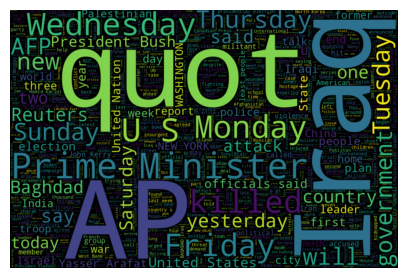

In [ ]:
# WordCloud para notícias classificadas como MUNDO

world = train_data[train_data['id'] == 1]['desc']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(
    min_font_size = 3,
    max_words = 2500,
    width = 1200,
    height = 800
).generate(' '.join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

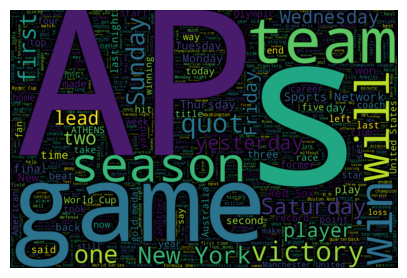

In [ ]:
# WordCloud para notícias classificadas como ESPORTES

sports = train_data[train_data['id'] == 2]['desc']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(
    min_font_size = 3,
    max_words = 2500,
    width = 1200,
    height = 800
).generate(' '.join(sports))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

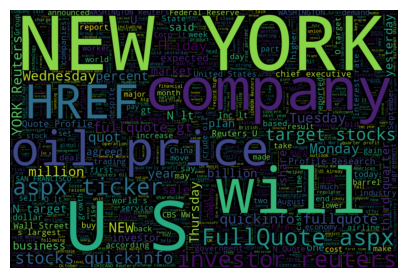

In [ ]:
# WordCloud para notícias classificadas como NEGÓCIOS

business = train_data[train_data['id'] == 3]['desc']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(
    min_font_size = 3,
    max_words = 2500,
    width = 1200,
    height = 800
).generate(' '.join(business))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

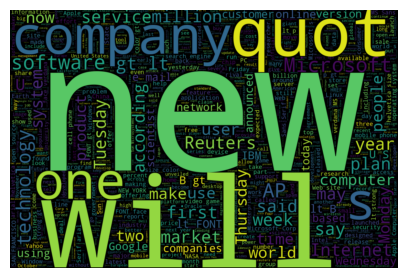

In [ ]:
# WordCloud para notícias classificadas como CIÊNCIA E TECNOLOGIA

tech = train_data[train_data['id'] == 4]['desc']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(
    min_font_size = 3,
    max_words = 2500,
    width = 1200,
    height = 800
).generate(' '.join(tech))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Limpeza do dataset

In [ ]:
# Remoção de tags HTML
def remove_html(text):
    html = re.compile('<.*?')
    cleaned_text = html.sub('', text)
    return cleaned_text
x_train = x_train.apply(remove_html)
x_test = x_test.apply(remove_html)

In [ ]:
# Remoção de URLs
def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    cleaned_text = url.sub(r'', text)
    return cleaned_text
x_train = x_train.apply(remove_urls)
x_test = x_test.apply(remove_urls)

In [ ]:
# Tokenização
def tokenize(text):
    token = re.findall("[\w']+", text)
    return token
x_train = x_train.apply(tokenize)
x_test = x_test.apply(tokenize)

In [ ]:
# Transformação em minúsculo
x_train = x_train.apply(lambda x: [word.lower() for word in x])
x_test = x_test.apply(lambda x: [word.lower() for word in x])

In [ ]:
# Remoção de stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text if word.lower() not in stop_words]
x_train = x_train.apply(remove_stopwords)
x_test = x_test.apply(remove_stopwords)

In [ ]:
# Remoção de pontuação
def remove_punct(text):
    return [''.join(char for char in word if char not in s.punctuation) for word in text]
x_train = x_train.apply(remove_punct)
x_test = x_test.apply(remove_punct)

In [ ]:
# Removendo números
def remove_numbers(text):
    return [''.join(char for char in word if char not in s.digits) for word in text if word]
x_train = x_train.apply(remove_numbers)
x_test = x_test.apply(remove_numbers)

In [ ]:
# Stemming
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
x_train = x_train.apply(stemming)
x_test = x_test.apply(stemming)

In [ ]:
# Removendo palavras extras
def remove_extra(text):
    extra_words = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    return [word for word in text if word not in extra_words]
x_train = x_train.apply(remove_extra)
x_test = x_test.apply(remove_extra)

In [ ]:
# Juntando lista de palavras em frases
def join_words(text):
    joined_text = ' '.join(text)
    return joined_text
x_train = x_train.apply(join_words)
x_test = x_test.apply(join_words)

## Extração de Features

In [ ]:
tfidf = TfidfVectorizer(min_df=8, ngram_range=(1, 3))
train_1 = tfidf.fit_transform(x_train)
test_1 = tfidf.transform(x_test)
print('Número de features extraídas: ')
print(len(tfidf.vocabulary_))
print('Primeiras 100 features: ')
print(list(tfidf.vocabulary_.keys())[:100])
train_arr = train_1.toarray()
test_arr = test_1.toarray()

Número de features extraídas: 
27485
Primeiras 100 features: 
['sprinter', 'jerom', 'young', 'ban', 'life', 'us', 'anti', 'dope', 'agenc', 'wednesday', 'follow', 'former', 'metr', 'world', 'champion', 'second', 'posit', 'test', 'illeg', 'steroid', 'us anti', 'anti dope', 'dope agenc', 'wednesday follow', 'world champion', 'illeg steroid', 'anti dope agenc', 'afp', 'australia', 'send', 'domest', 'intellig', 'agent', 'middl', 'east', 'specialist', 'train', 'part', 'major', 'effort', 'boost', 'fight', 'terror', 'head', 'countri', 'main', 'spi', 'said', 'afp australia', 'middl east', 'effort boost', 'fight terror', 'countri main', 'spi agenc', 'agenc said', 'polic', 'plan', 'file', 'murder', 'charg', 'sao', 'club', 'offici', 'death', 'collaps', 'field', 'die', 'heart', 'failur', 'last', 'month', 'die heart', 'heart failur', 'last month', 'danc', 'hotel', 'foot', 'mount', 'kenya', 'lost', 'audienc', 'rhythm', 'friday', 'tear', 'warrior', 'wangari', 'maathai', 'delight', 'name', 'year', 'win

In [ ]:
feature_names = tfidf.get_feature_names_out()
pd.DataFrame(train_arr[:100], columns=feature_names)

,aa,aapl,aaron,aaron peirsol,aaron rodger,ab,ababa,abandon,abba,abbey,...,zombi,zone,zoo,zook,zoom,zurich,zurich challeng,zurich reuter,zurich switzerland,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Naive Bayes

## Cálculo

In [ ]:
%%time
nb_multi = MultinomialNB(alpha=0.52)
nb_multi.fit(train_arr, y_train)
y_pred = nb_multi.predict(test_arr)

CPU times: user 7.22 s, sys: 1.8 s, total: 9.02 s
Wall time: 6.43 s


In [ ]:
print("Primeiras 20 classes reais")
print(y_test.tolist()[:20])
print("primeiras 20 classes calculadas")
print(y_pred.tolist()[:20])

Primeiras 20 classes reais
[1, 3, 1, 3, 2, 1, 1, 2, 3, 4, 2, 3, 3, 2, 3, 4, 2, 4, 4, 4]
primeiras 20 classes calculadas
[1, 3, 1, 4, 2, 1, 1, 2, 3, 4, 2, 3, 1, 2, 3, 4, 2, 4, 1, 4]


## Métricas

In [ ]:
print('F1 score do NB')
f1 = f1_score(y_test, y_pred, average='micro')
print(f1)
print('Acurácia do NB')
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
accuracy_pct = round(accuracy * 100, 3)
print(accuracy_pct, "%")

F1 score do NB
0.8992105263157895
Acurácia do NB
0.8992105263157895
89.921 %


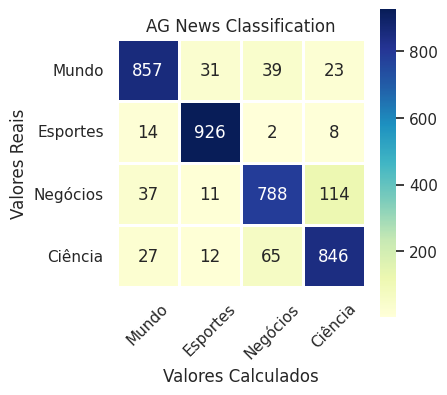

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index = ['Mundo', 'Esportes', 'Negócios', 'Ciência'],
    columns = ['Mundo', 'Esportes', 'Negócios', 'Ciência']
)
sns.set(font_scale=1)
plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix_df,
    cmap = 'YlGnBu',
    linewidths = 1,
    annot = True,
    square = True,
    cbar = True,
    fmt = 'd'
)
plt.xlabel('Valores Calculados')
plt.ylabel('Valores Reais')
plt.title('AG News Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Árvore de Decisão

## Cálculo

In [ ]:
%%time
tree = DecisionTreeClassifier()
tree.fit(train_arr, y_train)
y_pred = tree.predict(test_arr)

print("Primeiras 20 classes reais")
print(y_test.tolist()[:20])
print("primeiras 20 classes calculadas")
print(y_pred.tolist()[:20])

Primeiras 20 classes reais
[1, 3, 1, 3, 2, 1, 1, 2, 3, 4, 2, 3, 3, 2, 3, 4, 2, 4, 4, 4]
primeiras 20 classes calculadas
[1, 3, 1, 4, 2, 1, 1, 2, 3, 4, 2, 3, 1, 2, 3, 4, 4, 3, 1, 4]
CPU times: user 35min 17s, sys: 8.78 s, total: 35min 26s
Wall time: 35min 31s


## Métricas

In [ ]:
print('F1 score da árvore de decisão')
f1 = f1_score(y_test, y_pred, average='micro')
print(f1)
print('Acurácia da árvore de decisão')
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
accuracy_pct = round(accuracy * 100, 3)
print(accuracy_pct, "%")

F1 score da árvore de decisão
0.7902631578947369
Acurácia da árvore de decisão
0.7902631578947369
79.026 %


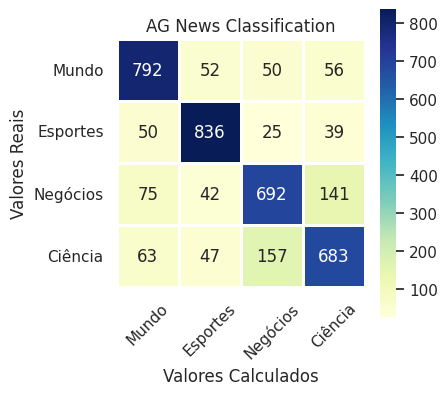

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index = ['Mundo', 'Esportes', 'Negócios', 'Ciência'],
    columns = ['Mundo', 'Esportes', 'Negócios', 'Ciência']
)
sns.set(font_scale=1)
plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix_df,
    cmap = 'YlGnBu',
    linewidths = 1,
    annot = True,
    square = True,
    cbar = True,
    fmt = 'd'
)
plt.xlabel('Valores Calculados')
plt.ylabel('Valores Reais')
plt.title('AG News Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()